In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import Pipeline
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 1. Load the data

In [76]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# 2. Exploratory Data Analysis

In [77]:
train_data.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [78]:
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Display basic statistics
print("\nTraining data summary:")

Training data shape: (2190, 13)
Test data shape: (730, 12)

Training data summary:


In [79]:
print(train_data.describe())

                id          day     pressure      maxtemp  temparature  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean   1094.500000   179.948402  1013.602146    26.365799    23.953059   
std     632.342866   105.203592     5.655366     5.654330     5.222410   
min       0.000000     1.000000   999.000000    10.400000     7.400000   
25%     547.250000    89.000000  1008.600000    21.300000    19.300000   
50%    1094.500000   178.500000  1013.000000    27.800000    25.500000   
75%    1641.750000   270.000000  1017.775000    31.200000    28.400000   
max    2189.000000   365.000000  1034.600000    36.000000    31.500000   

           mintemp     dewpoint     humidity        cloud     sunshine  \
count  2190.000000  2190.000000  2190.000000  2190.000000  2190.000000   
mean     22.170091    20.454566    82.036530    75.721918     3.744429   
std       5.059120     5.288406     7.800654    18.026498     3.626327   
min       4.000000    -0.300000    39

# statistical insights:
## 
### **temperature:**
### - the maximum temperature ranges from **10.4°c** to **36.0°c**, with a mean of approximately **26.4°c**.
### - the minimum temperature ranges from **-0.3°c** to **30.0°c**, indicating a wide range of temperature conditions.
### 
### **humidity:**
### - the average humidity is around **82.0%**, with a maximum of **98.0%**. this suggests a generally humid environment, which is conducive to rainfall.
### 
### **pressure:**
### - atmospheric pressure ranges from **989.0 hpa** to **1034.6 hpa**, with a mean of about **1013.6 hpa**. this is within the normal range for atmospheric pressure.
### 
### **cloud cover:**
### - the average cloud cover is approximately **75.7%**, with a maximum of **100%**. high cloud cover is often associated with increased chances of precipitation.
### 
### **sunshine:**
### - the average sunshine hours are low (mean of **3.7 hours**), which may correlate with higher rainfall probabilities.
### 
### **wind:**
### - wind speed averages around **21.8 km/h**, with a maximum of **59.5 km/h**. high wind speeds can influence weather patterns and precipitation.
### 
### **rainfall:**
### - the dataset shows a binary outcome for rainfall, with a mean of **0.75**, indicating that it rained on approximately **75%** of the days in the dataset. this suggests a significant prevalence of rainy days.


Missing values in training data:
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

Missing values in test data:
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64


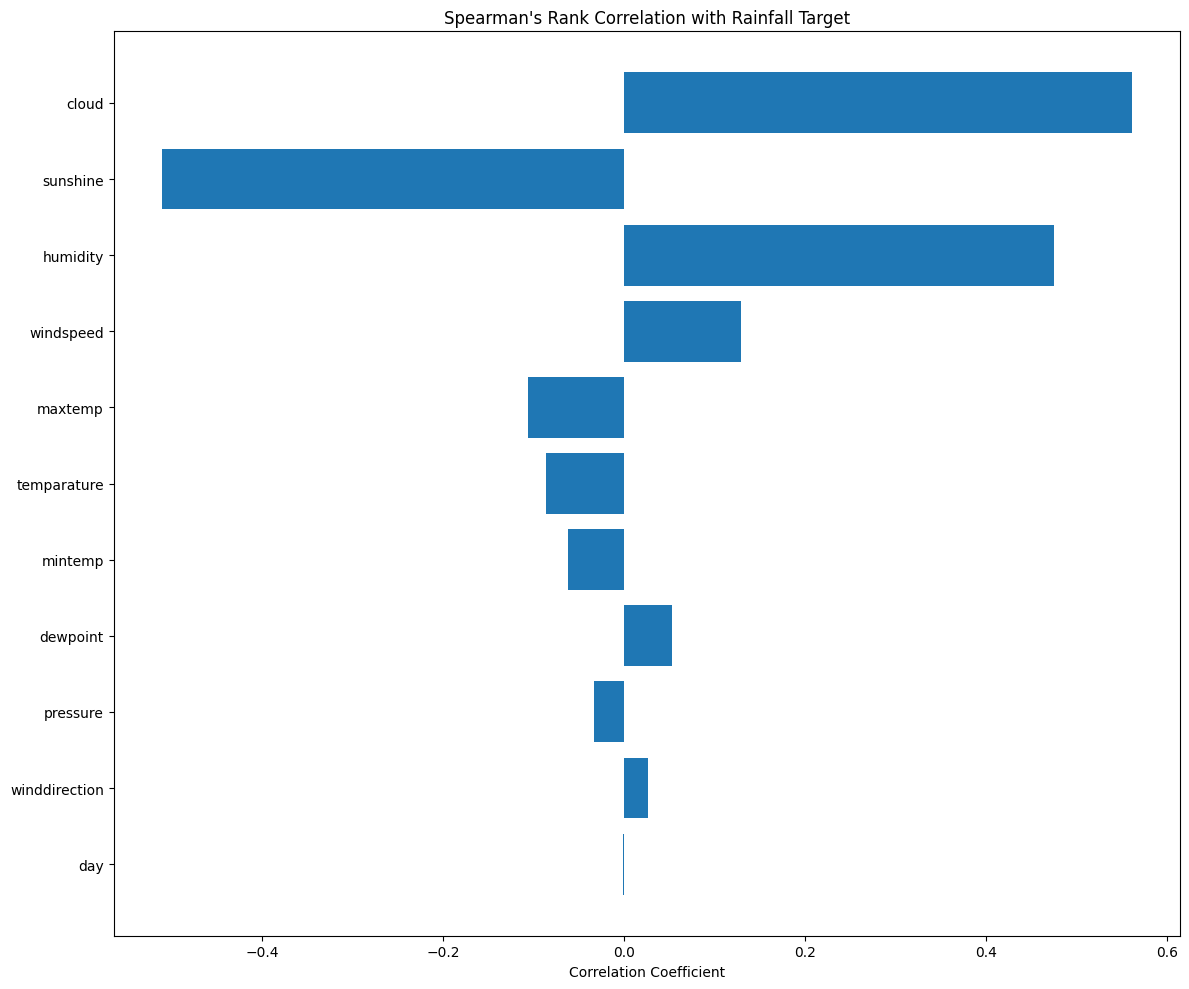

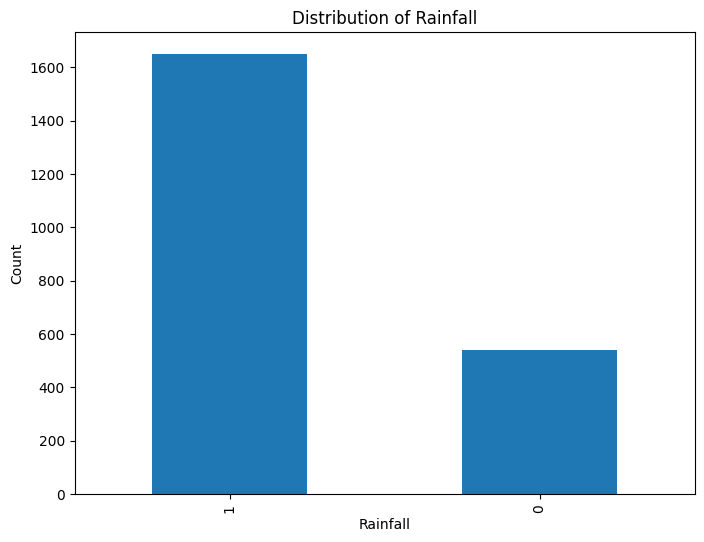

In [80]:
# Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum())
print("\nMissing values in test data:")
print(test_data.isnull().sum())

# Calculate Spearman's Rank Correlation with rainfall target
correlations = []
features = train_data.drop(['id', 'rainfall'], axis=1).columns
for feature in features:
    correlation = train_data[feature].corr(train_data['rainfall'], method='spearman')
    correlations.append({'Feature': feature, 'Correlation': correlation})

# Create dataframe and sort by absolute correlation
correlations_df = pd.DataFrame(correlations)
correlations_df['Abs_Correlation'] = correlations_df['Correlation'].abs()
correlations_df = correlations_df.sort_values('Abs_Correlation', ascending=True)

# Plot Spearman's Rank correlations
plt.figure(figsize=(12, 10))
plt.barh(correlations_df['Feature'], correlations_df['Correlation'])
plt.title("Spearman's Rank Correlation with Rainfall Target")
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Distribution of target variable
plt.figure(figsize=(8, 6))
train_data['rainfall'].value_counts().plot(kind='bar')
plt.title('Distribution of Rainfall')
plt.xlabel('Rainfall')
plt.ylabel('Count')
plt.show()

#### Spearman's Rank Correlation Insights:
- The strong positive correlations of cloud and sunshine suggest that these meteorological factors are critical in predicting rainfall. This could guide feature selection for model training.
- The weak correlations of certain features (like "day" and "pressure") may indicate that they could be candidates for removal or require transformation to improve model performance.

#### Distribution of target variable Insights:
- The imbalance in the target variable indicates that the model may be biased towards predicting the majority class (rainfall = 1). Techniques such as resampling (oversampling the minority class or undersampling the majority class) or using different evaluation metrics (like F1-score, precision, and recall) may be necessary to ensure the model performs well across both classes.
- The imbalance in the target variable (many more non-rainy days than rainy days) indicates that the model may struggle to predict rare events accurately.


# 3. Data Preprocessing

In [81]:
# Separate features and target
X = train_data.drop(['id', 'rainfall'], axis=1)
y = train_data['rainfall']
test_features = test_data.drop('id', axis=1)

# Handle missing values in the test set
# Looking at the missing values output above, we'll impute them if needed
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
test_imputed = imputer.transform(test_features)

# Split the data for validation
X_train, X_val, y_train, y_val = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


# 4. Feature Importance Analysis

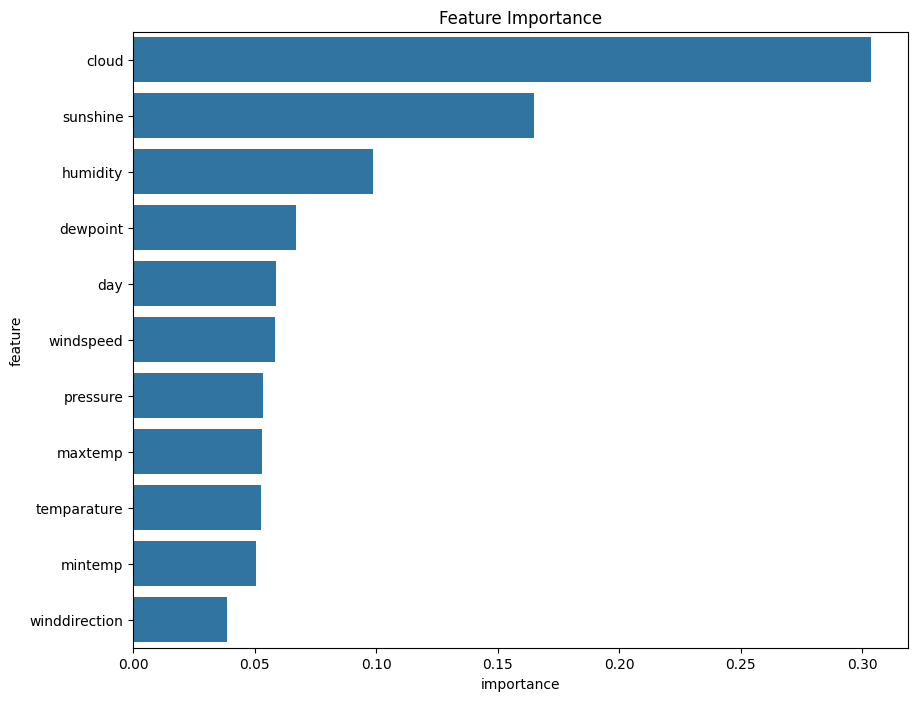

In [82]:

# Train a simple random forest to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf = xgb.XGBClassifier(random_state=42)

rf.fit(X_train, y_train)

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

# Implications for Model Development
* Feature Selection: Given the importance scores, you might consider focusing on the top features (cloud, sunshine, humidity, and dewpoint) for model training. This could simplify the model and reduce overfitting.
* Feature Engineering: Since cloud cover and humidity are critical, you might explore creating additional features related to these variables, such as lag features or interaction terms.
* Model Interpretation: Understanding which features are most important can help in interpreting model predictions and making informed decisions based on the results.
Potential for Improvement: If the model's performance is not satisfactory, consider revisiting the lower importance features. They might still hold some predictive power when combined with other features or through transformations.

# 4. Feature Engineering


In [83]:
import pandas as pd

# Load the data
data = pd.read_csv('train.csv')

# Create lag features
data['temp_lag_1'] = data['temparature'].shift(1)  # Lag of 1 day
data['temp_lag_2'] = data['temparature'].shift(2)  # Lag of 2 days
data['cloud_lag_1'] = data['cloud'].shift(1)  # Lag of 1 day
data['cloud_lag_2'] = data['cloud'].shift(2)  # Lag of 2 days
data['sunshine_lag_1'] = data['sunshine'].shift(1)  # Lag of 1 day
data['sunshine_lag_2'] = data['sunshine'].shift(2)  # Lag of 2 days
data['humidity_lag_1'] = data['humidity'].shift(1)  # Lag of 1 day
data['humidity_lag_2'] = data['humidity'].shift(2)  # Lag of 2 days

# Create rolling average features
data['rolling_avg_temp_3'] = data['temparature'].rolling(window=7).mean()  # 3-day rolling average
data['rolling_avg_cloud_3'] = data['cloud'].rolling(window=7).mean()  # 3-day rolling average
data['rolling_avg_sunshine_3'] = data['sunshine'].rolling(window=7).mean()  # 3-day rolling average
data['rolling_avg_humidity_3'] = data['humidity'].rolling(window=7).mean()  # 3-day rolling average

# Create difference features
data['temp_diff'] = data['temparature'] - data['temparature'].shift(1)  # Difference from previous day
data['cloud_diff'] = data['cloud'] - data['cloud'].shift(1)  # Difference from previous day
data['sunshine_diff'] = data['sunshine'] - data['sunshine'].shift(1)  # Difference from previous day
data['humidity_diff'] = data['humidity'] - data['humidity'].shift(1)  # Difference from previous day

# Create binary features based on thresholds
data['is_high_temp'] = (data['temparature'] > data['temparature'].quantile(0.95)).astype(int)
data['is_high_cloud'] = (data['cloud'] > data['cloud'].quantile(0.95)).astype(int)
data['is_high_sunshine'] = (data['sunshine'] > data['sunshine'].quantile(0.95)).astype(int)
data['is_high_humidity'] = (data['humidity'] > data['humidity'].quantile(0.95)).astype(int)
data['is_high_windspeed'] = (data['windspeed'] > data['windspeed'].quantile(0.95)).astype(int)
data['is_high_winddirection'] = (data['winddirection'] > data['winddirection'].quantile(0.95)).astype(int)
data['is_high_pressure'] = (data['pressure'] > data['pressure'].quantile(0.95)).astype(int)
data['is_high_dewpoint'] = (data['dewpoint'] > data['dewpoint'].quantile(0.95)).astype(int)
data['is_low_temp'] = (data['temparature'] < data['temparature'].quantile(0.05)).astype(int)
data['is_low_cloud'] = (data['cloud'] < data['cloud'].quantile(0.05)).astype(int)
data['is_low_sunshine'] = (data['sunshine'] < data['sunshine'].quantile(0.05)).astype(int)
data['is_low_humidity'] = (data['humidity'] < data['humidity'].quantile(0.05)).astype(int)
data['is_low_windspeed'] = (data['windspeed'] < data['windspeed'].quantile(0.05)).astype(int)
data['is_low_winddirection'] = (data['winddirection'] < data['winddirection'].quantile(0.05)).astype(int)
data['is_low_pressure'] = (data['pressure'] < data['pressure'].quantile(0.05)).astype(int)
data['is_low_dewpoint'] = (data['dewpoint'] < data['dewpoint'].quantile(0.05)).astype(int)


# Define the base date (e.g., January 1 of the desired year)
base_date = '2023-01-01'

# Convert day numbers to datetime
data['date'] = pd.to_datetime(base_date) + pd.to_timedelta(data['day'] - 1, unit='d')

# Create seasonal features (assuming 'date' is a column in your data)
data['date'] = pd.to_datetime(data['date'])  # Convert to datetime
data['month'] = data['date'].dt.month  # Extract month
data['season'] = (data['month'] % 12 + 3) // 3  # 1: Spring, 2: Summer, 3: Fall, 4: Winter

data.drop(columns=['date'], axis=1, inplace=True)

# Save the new features to a new CSV
data.to_csv('train_with_features.csv', index=False)

In [84]:
train_with_features = pd.read_csv('train_with_features.csv')
train_with_features.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,...,is_low_temp,is_low_cloud,is_low_sunshine,is_low_humidity,is_low_windspeed,is_low_winddirection,is_low_pressure,is_low_dewpoint,month,season
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,...,0,0,0,0,0,0,0,0,1,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,...,0,0,0,0,0,0,0,0,1,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,...,0,0,0,0,0,0,0,1,1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,...,0,0,0,0,0,0,0,0,1,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,...,0,0,0,1,0,0,0,1,1,1


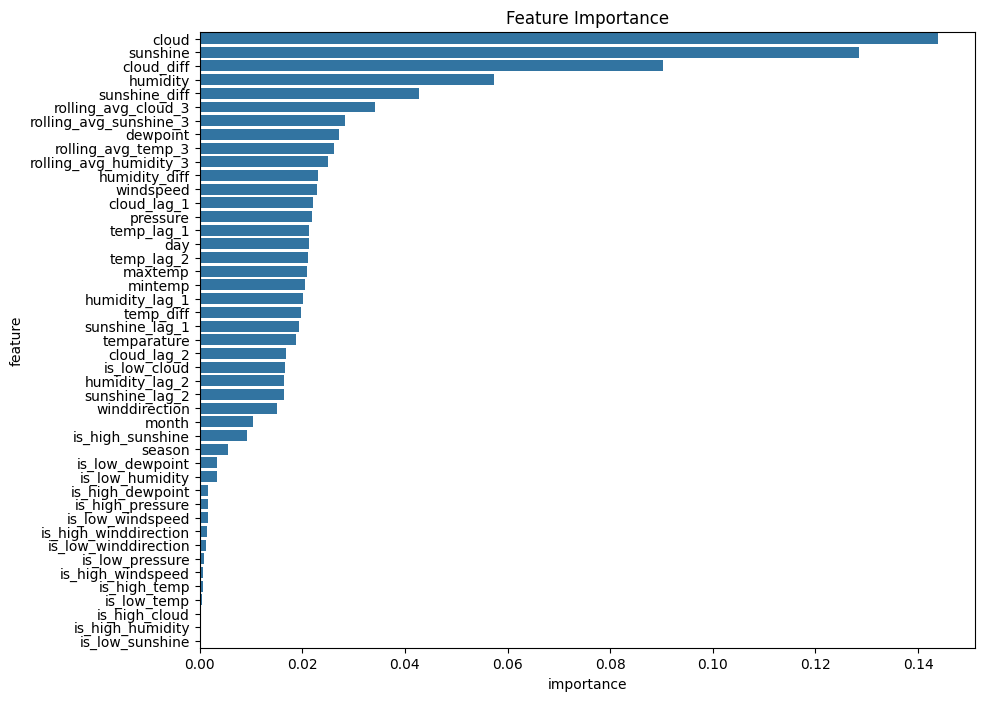

In [ ]:
train_with_features = pd.read_csv('train_with_features.csv')

#drop the columns less important
# train_with_features = train_with_features.drop(['day', 'pressure', 'maxtemp', 'mintemp', 'dewpoint', 'winddirection', 'windspeed'], axis=1)

# Separate features and target
X = train_with_features.drop(['id', 'rainfall'], axis=1)
y = train_with_features['rainfall']
test_features = test_data.drop('id', axis=1)

# # Handle missing values in the test set
# # Looking at the missing values output above, we'll impute them if needed
# imputer = SimpleImputer(strategy='median')
# X_imputed = imputer.fit_transform(X)
# test_imputed = imputer.transform(test_features)

# Split the data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple random forest to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf = xgb.XGBClassifier(random_state=42)
rf.fit(X_train, y_train)

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

# Conclusion
The feature importance analysis highlights the critical role of cloud cover, sunshine, and humidity in predicting rainfall. By leveraging this information, you can enhance your model's performance and gain deeper insights into the factors influencing rainfall. The presence of lag and rolling average features suggests that temporal patterns are also significant, indicating the importance of recent weather conditions in making predictions

# 5. Model Training and Evaluation

In [87]:
train_with_features.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,...,is_low_temp,is_low_cloud,is_low_sunshine,is_low_humidity,is_low_windspeed,is_low_winddirection,is_low_pressure,is_low_dewpoint,month,season
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,...,0,0,0,0,0,0,0,0,1,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,...,0,0,0,0,0,0,0,0,1,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,...,0,0,0,0,0,0,0,1,1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,...,0,0,0,0,0,0,0,0,1,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,...,0,0,0,1,0,0,0,1,1,1


In [89]:
# filter the features based on top 9 of the feature importance
top_features = feature_importance.head(20)['feature'].values
print("top features: ", top_features)

# X = train_with_features.drop(['id', 'rainfall'], axis=1)
X = train_with_features[top_features]
y = train_with_features['rainfall']

# Split the data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

top features:  ['cloud' 'sunshine' 'cloud_diff' 'humidity' 'sunshine_diff'
 'rolling_avg_cloud_3' 'rolling_avg_sunshine_3' 'dewpoint'
 'rolling_avg_temp_3' 'rolling_avg_humidity_3' 'humidity_diff' 'windspeed'
 'cloud_lag_1' 'pressure' 'temp_lag_1' 'day' 'temp_lag_2' 'maxtemp'
 'mintemp' 'humidity_lag_1']


## 5.1 Random Forest

In [90]:
print("\nRandom Forest Classifier:")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
rf_model.fit(X_train, y_train)
rf_val_pred = rf_model.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, rf_val_pred)
print(f"Validation AUC: {rf_auc:.4f}")


Random Forest Classifier:
Validation AUC: 0.8690


## 5.2 Gradient Boosting

In [91]:
print("\nGradient Boosting Classifier:")
gb_model = GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
gb_model.fit(X_train.fillna(0), y_train.fillna(0))
gb_val_pred = gb_model.predict_proba(X_val)[:, 1]
gb_auc = roc_auc_score(y_val, gb_val_pred)
print(f"Validation AUC: {gb_auc:.4f}")


Gradient Boosting Classifier:
Validation AUC: 0.8560


## 5.3 XGBoost

In [92]:
print("\nXGBoost Classifier:")
xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_val_pred = xgb_model.predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(y_val, xgb_val_pred)
print(f"Validation AUC: {xgb_auc:.4f}")


XGBoost Classifier:
Validation AUC: 0.8585


# ROC curves comparison

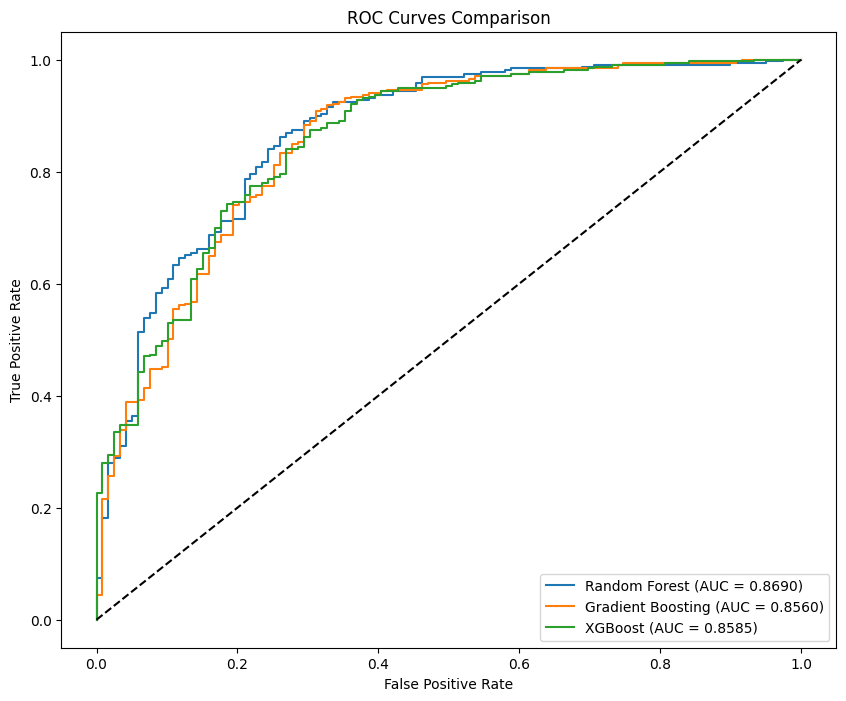

In [93]:
plt.figure(figsize=(10, 8))
# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_val_pred)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.4f})')

# Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_val, gb_val_pred)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_auc:.4f})')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, xgb_val_pred)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

# 6. Hyperparameter Tuning

In [96]:
# Use the best model from above (assuming XGBoost based on performance) and fine-tune it
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [25, 50, 75, 100, 200],
    'max_depth': [3, 5, 7, 10, 15, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'objective': ['binary:logistic']
}

# You might want to uncomment this for more in-depth tuning, but it can be time-consuming
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X, y)
best_params = grid_search.best_params_
print("\nBest parameters:", best_params)

# For now, let's use a good set of parameters based on experience
# best_params = {
#     'n_estimators': 200,
#     'max_depth': 5,
#     'learning_rate': 0.05,
#     'subsample': 0.9,
#     'colsample_bytree': 0.9
# }


Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 75, 'objective': 'binary:logistic', 'subsample': 0.8}


# 7. Final Model Training

In [97]:
final_model = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    # colsample_bytree=best_params['colsample_bytree'],
    objective=best_params['objective'],
    random_state=42
)

# Train on the full dataset
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# 8. Make predictions on the test set

In [98]:
X.columns

Index(['cloud', 'sunshine', 'cloud_diff', 'humidity', 'sunshine_diff',
       'rolling_avg_cloud_3', 'rolling_avg_sunshine_3', 'dewpoint',
       'rolling_avg_temp_3', 'rolling_avg_humidity_3', 'humidity_diff',
       'windspeed', 'cloud_lag_1', 'pressure', 'temp_lag_1', 'day',
       'temp_lag_2', 'maxtemp', 'mintemp', 'humidity_lag_1'],
      dtype='object')

In [99]:
# create the new features for test
test_with_features = test_data.copy()

test_with_features['cloud_diff'] = test_with_features['cloud'] - test_with_features['cloud'].shift(1)
test_with_features['sunshine_diff'] = test_with_features['sunshine'] - test_with_features['sunshine'].shift(1)
test_with_features['humidity_diff'] = test_with_features['humidity'] - test_with_features['humidity'].shift(1)
test_with_features['cloud_lag_1'] = test_with_features['cloud'].shift(1)
test_with_features['temp_lag_1'] = test_with_features['temparature'].shift(1)
test_with_features['temp_lag_2'] = test_with_features['temparature'].shift(2)
test_with_features['humidity_lag_1'] = test_with_features['humidity'].shift(1)
test_with_features['rolling_avg_cloud_3'] = test_with_features['cloud'].rolling(window=3).mean()
test_with_features['rolling_avg_sunshine_3'] = test_with_features['sunshine'].rolling(window=3).mean()
test_with_features['rolling_avg_humidity_3'] = test_with_features['humidity'].rolling(window=3).mean()
test_with_features['rolling_avg_temp_3'] = test_with_features['temparature'].rolling(window=3).mean()


# Select the specified features for test_with_features
test_with_features = test_with_features[['cloud', 'sunshine', 'cloud_diff', 'humidity', 'sunshine_diff',
       'rolling_avg_cloud_3', 'rolling_avg_sunshine_3', 'dewpoint',
       'rolling_avg_temp_3', 'rolling_avg_humidity_3', 'humidity_diff',
       'windspeed', 'cloud_lag_1', 'pressure', 'temp_lag_1', 'day',
       'temp_lag_2', 'maxtemp', 'mintemp', 'humidity_lag_1']]

In [100]:
test_pred_proba = final_model.predict_proba(test_with_features)[:, 1]


# 9. Create submission file


Submission file created successfully!


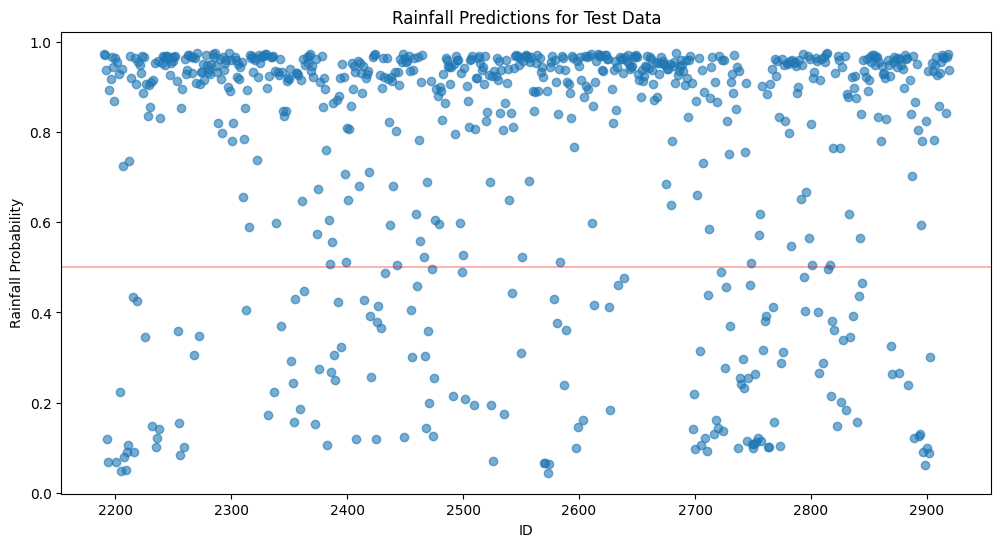

In [ ]:
submission['rainfall'] = test_pred_proba
submission.to_csv('rainfall_prediction_submission_xgboost_hyperparameter_tuning.csv', index=False)

print("\nSubmission file created successfully!")

# Visualize a few predictions
plt.figure(figsize=(12, 6))
plt.scatter(test_data['id'], test_pred_proba, alpha=0.6)
plt.axhline(y=0.5, color='r', linestyle='-', alpha=0.3)
plt.title('Rainfall Predictions for Test Data')
plt.xlabel('ID')
plt.ylabel('Rainfall Probability')
plt.show()

# 10. Feature Importance of Final Model

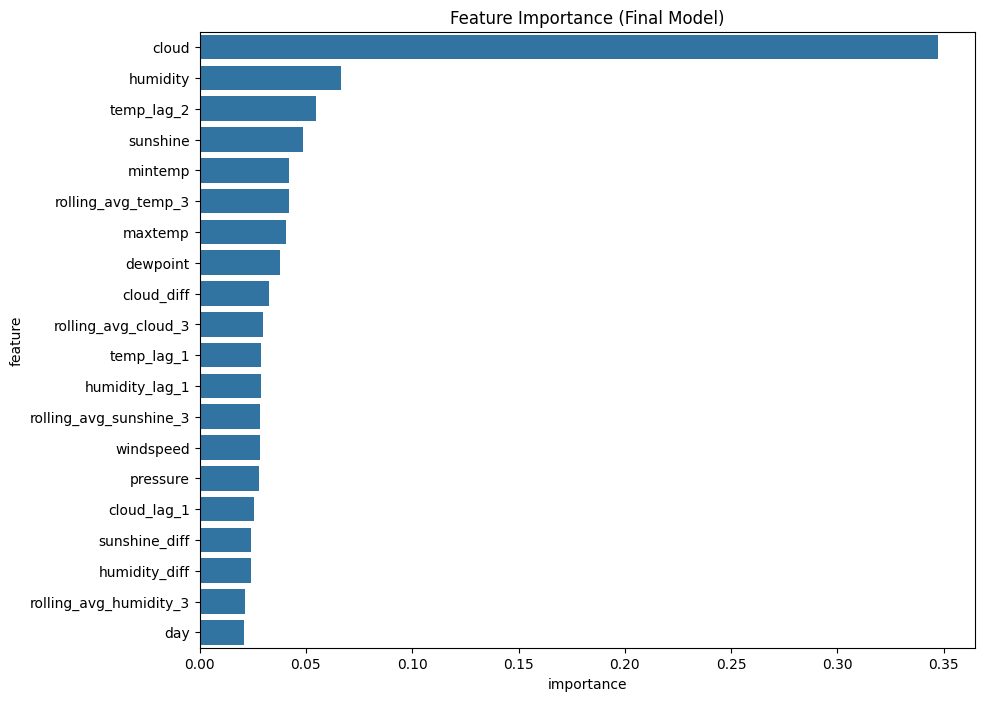

In [106]:
feature_importance_final = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_final)
plt.title('Feature Importance (Final Model)')
plt.show()

# 11. Additional Analysis

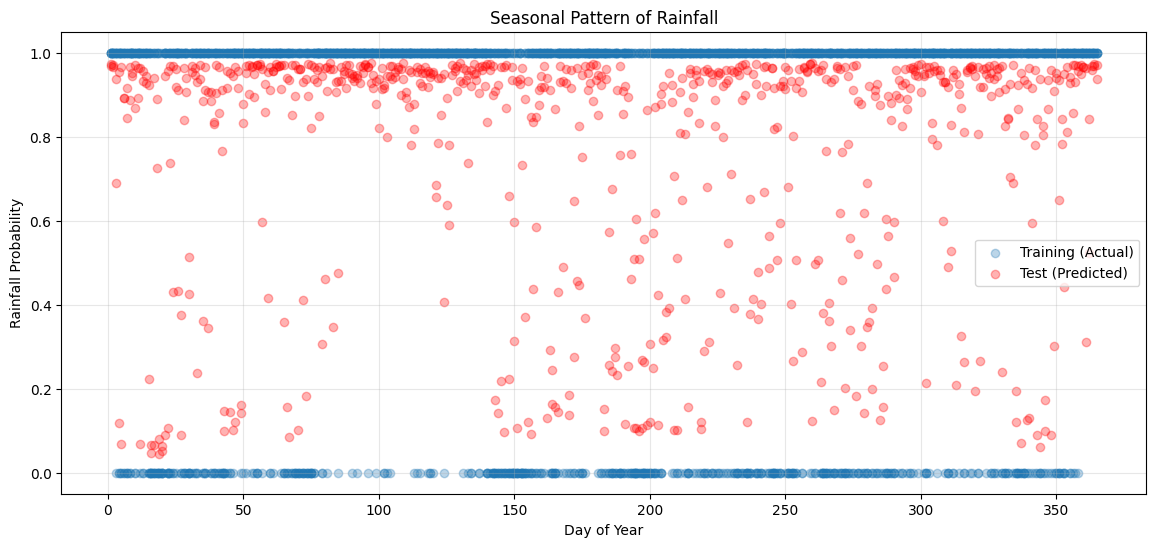

ValueError: Could not interpret value `temp_lag_2` for `y`. An entry with this name does not appear in `data`.

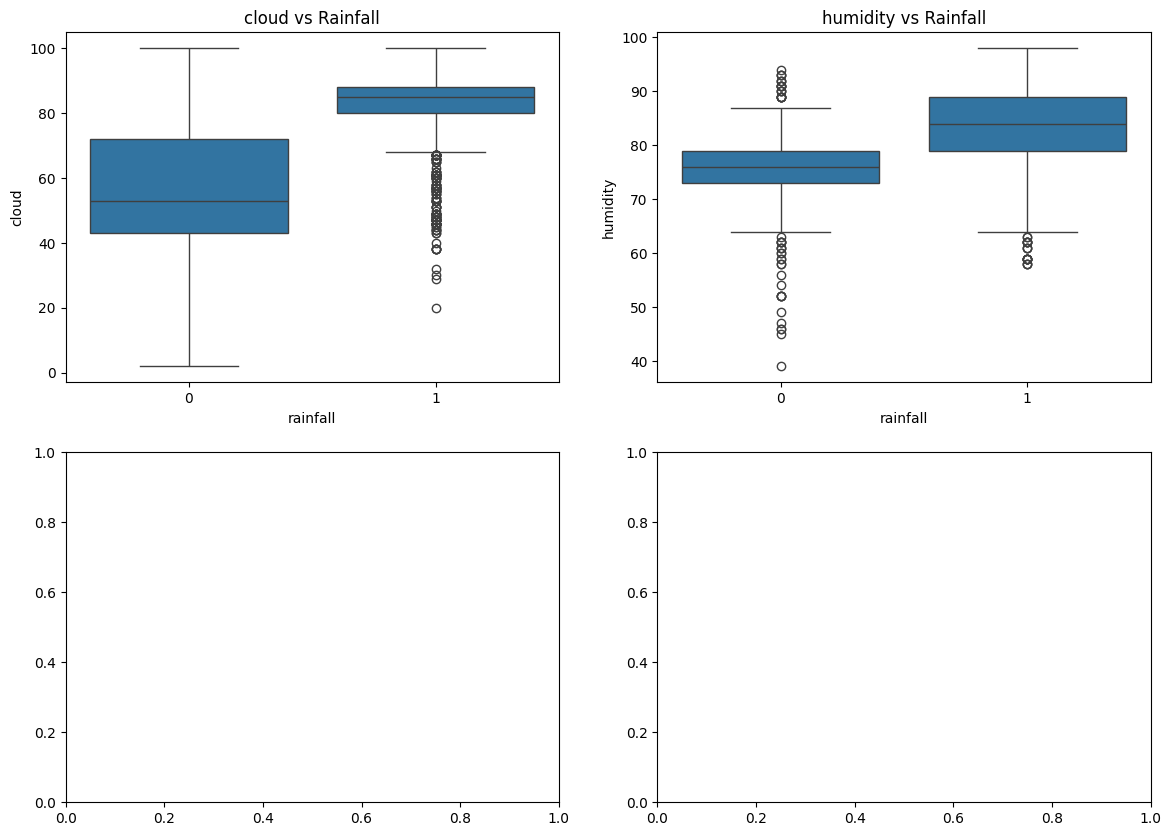

In [107]:
# Seasonal patterns
train_data['prediction'] = 0  # Just for visualization
test_prediction_df = pd.DataFrame({
    'day': test_data['day'],
    'prediction': test_pred_proba
})

# Combine for visualization
plt.figure(figsize=(14, 6))
plt.scatter(train_data['day'], train_data['rainfall'], alpha=0.3, label='Training (Actual)')
plt.scatter(test_data['day'], test_pred_proba, alpha=0.3, label='Test (Predicted)', color='red')
plt.title('Seasonal Pattern of Rainfall')
plt.xlabel('Day of Year')
plt.ylabel('Rainfall Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Relationship between important features and rainfall
top_features = feature_importance_final.head(4)['feature'].values

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    sns.boxplot(x='rainfall', y=feature, data=train_data, ax=axes[i])
    axes[i].set_title(f'{feature} vs Rainfall')
    
plt.tight_layout()
plt.show()

print("Analysis complete!")